
<div style="font-size: 40px;">
    
**Quadratic Programming - Variable production costs depending on output levels**
</div>

1️⃣ **Install & Import**

In [1]:
!pip install docplex


Defaulting to user installation because normal site-packages is not writeable


In [47]:
from docplex.mp.model import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(1447)

In [72]:
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 2000

In [73]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

2️⃣ **Read Data**

In [74]:
# Notebook and data folder in same directory
countries = ["USA", "GERMANY", "JAPAN", "BRAZIL", "INDIA"]

# Read all Excel files
demand_df = pd.read_excel("data/demand (1).xlsx", index_col=0)
capacity_df = pd.read_excel("data/capacity (1).xlsx", index_col=0)
fixed_cost_df = pd.read_excel("data/fixed cost.xlsx", index_col=0)
variable_cost_df = pd.read_excel("data/variable costs.xlsx", index_col=0)
freight_cost_df = pd.read_excel("data/freight costs.xlsx", index_col=0)

# Convert to dictionaries / matrices
demand = demand_df["Demand"].to_dict()
capacity_low = capacity_df["LOW"].to_dict()
capacity_high = capacity_df["HIGH"].to_dict()
fixed_low = fixed_cost_df["LOW"].to_dict()
fixed_high = fixed_cost_df["HIGH"].to_dict()
var_costs = variable_cost_df.loc[countries, countries].to_numpy()  # production cost matrix
freight_costs = freight_cost_df.loc[countries, countries].to_numpy() / 1000.0  # per-unit


In [75]:
demand_df

,Demand
(Units/month),
USA,2800000
GERMANY,90000
JAPAN,1700000
BRAZIL,145000
INDIA,160000


In [59]:
capacity_df
# print('small scale plant capacity(in units/month): ',capacity_low)
# print('large scale plant capacity(in units/month): ',capacity_high)

,LOW,HIGH
Capacity (Units/month),,
USA,500000,1500000
GERMANY,500000,1500000
JAPAN,500000,1500000
BRAZIL,500000,1500000
INDIA,500000,1500000


In [60]:
fixed_cost_df
# print('small plant fixed costs($/month): ', fixed_low)
# print('large plant fixed costs($/month): ', fixed_high)

,LOW,HIGH
Plant Fixed Cost($/MONTH),,
USA,6500000,9500000
GERMANY,4980000,7270000
JAPAN,6230000,9100000
BRAZIL,3230000,4730000
INDIA,2110000,6160000


In [61]:
variable_cost_df

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Variable Costs ($/Unit),,,,,
USA,12,12,12,12,12
GERMANY,13,13,13,13,13
JAPAN,10,10,10,10,10
BRAZIL,8,8,8,8,8
INDIA,5,5,5,5,5


In [35]:
# print('variable production costs($/unit): \n',var_costs)
# print('variable transportation costs($/unit): \n',freight_costs)

variable production costs($/unit): 
 [[12 12 12 12 12]
 [13 13 13 13 13]
 [10 10 10 10 10]
 [ 8  8  8  8  8]
 [ 5  5  5  5  5]]
variable transportation costs($/unit): 
 [[0.    1.75  1.1   2.3   1.254]
 [1.905 0.    1.231 2.892 1.439]
 [2.2   3.25  0.    6.23  2.05 ]
 [2.35  3.15  4.    0.    4.25 ]
 [1.95  2.2   3.5   4.2   0.   ]]


In [77]:
freight_cost_df

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Freight Costs ($/Container),,,,,
USA,0,1750,1100,2300,1254
GERMANY,1905,0,1231,2892,1439
JAPAN,2200,3250,0,6230,2050
BRAZIL,2350,3150,4000,0,4250
INDIA,1950,2200,3500,4200,0


**Visualization of Data**

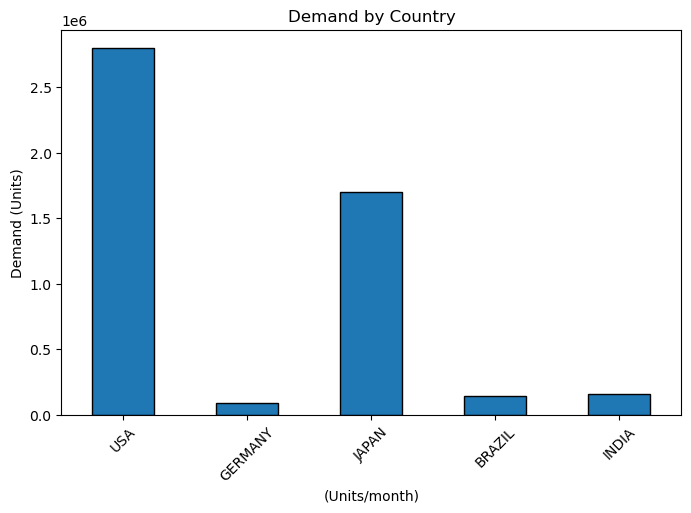

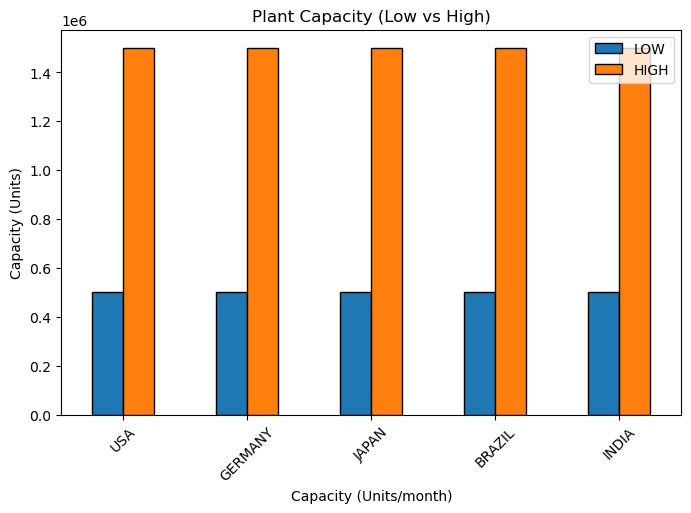

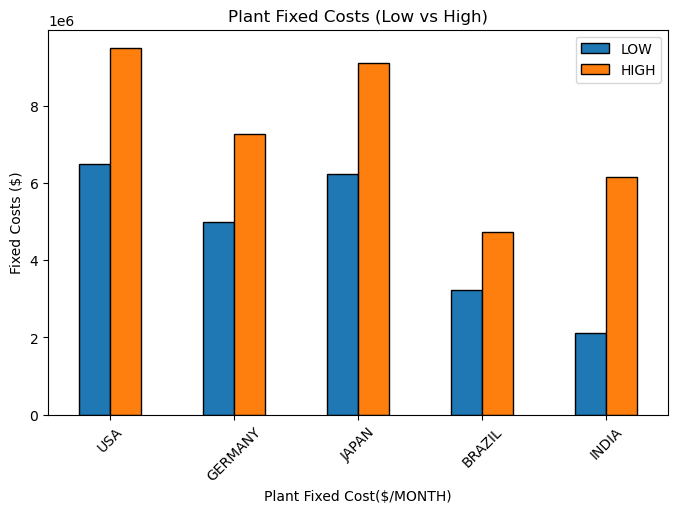

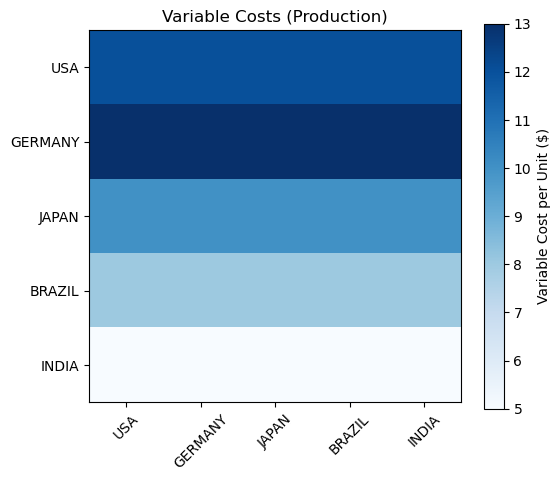

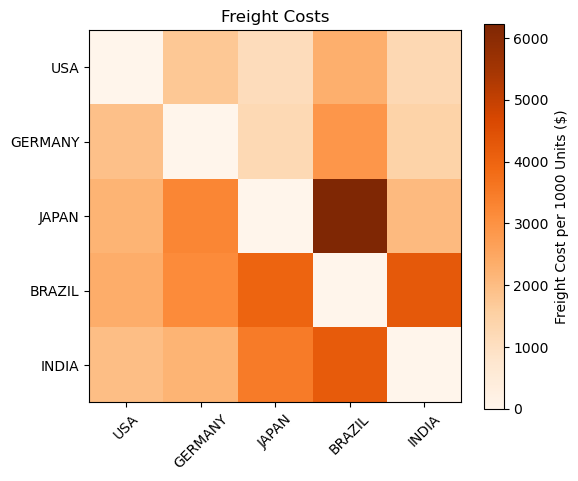

In [91]:
# Demand plot
demand_df.plot(kind="bar", figsize=(8,5), legend=False, color="tab:blue", edgecolor="black")
plt.ylabel("Demand (Units)")
plt.title("Demand by Country")
plt.xticks(rotation=45)
plt.show()

# Capacity plot (Low vs High)
capacity_df.plot(kind="bar", figsize=(8,5), edgecolor="black")
plt.ylabel("Capacity (Units)")
plt.title("Plant Capacity (Low vs High)")
plt.xticks(rotation=45)
plt.show()

# Fixed costs plot (Low vs High)
fixed_cost_df.plot(kind="bar", figsize=(8,5), edgecolor="black")
plt.ylabel("Fixed Costs ($)")
plt.title("Plant Fixed Costs (Low vs High)")
plt.xticks(rotation=45)
plt.show()

# Variable costs heatmap
plt.figure(figsize=(6,5))
plt.imshow(variable_cost_df, cmap="Blues")
plt.colorbar(label="Variable Cost per Unit ($)")
plt.xticks(range(len(countries)), countries, rotation=45)
plt.yticks(range(len(countries)), countries)
plt.title("Variable Costs (Production)")
plt.show()

# Freight costs heatmap
plt.figure(figsize=(6,5))
plt.imshow(freight_cost_df, cmap="Oranges")
plt.colorbar(label="Freight Cost per 1000 Units ($)")
plt.xticks(range(len(countries)), countries, rotation=45)
plt.yticks(range(len(countries)), countries)
plt.title("Freight Costs")
plt.show()

**checking condition if capacity is greater than demand **

In [36]:
print("Total demand:", sum(demand.values()))
print("Total capacity:", sum(capacity_high.values()))

Total demand: 4895000
Total capacity: 7500000


3️⃣ **Create Model & Variables**

In [37]:
# Create CPLEX model
mdl = Model("SupplyChain_MI_QP")

n = len(countries)

# Decision variables
# x[i,j] = units shipped from plant i to market j (continuous)
x = {(i,j): mdl.continuous_var(lb=0, name=f"x_{i}_{j}") 
     for i in range(n) for j in range(n)}

# y[i] = 1 if plant i is active, 0 otherwise (binary)
y = {i: mdl.binary_var(name=f"y_{i}") for i in range(n)}


4️⃣ **Set Objective Function**

In [78]:
# Quadratic production costs + fixed cost + transportation
b = [1e-6, 1.2e-6, 0.8e-6, 1.5e-6, 0.5e-6]  # quadratic cost coefficients

total_cost = mdl.sum(
    var_costs[i,i] * x[i,j] + b[i] * x[i,j]*x[i,j] + (freight_costs[i,j]) * x[i,j]
    for i in range(n) for j in range(n)
) + mdl.sum(fixed_high[countries[i]] * y[i] for i in range(n))

mdl.minimize(total_cost)


5️⃣ **Add Constraints**

In [79]:
# 1. Meet demand in each country
for j in range(n):
    mdl.add_constraint(mdl.sum(x[i,j] for i in range(n)) == demand[countries[j]], 
                       ctname=f"demand_{j}")

# 2. Plant capacity (link to activation)
for i in range(n):
    mdl.add_constraint(mdl.sum(x[i,j] for j in range(n)) <= capacity_high[countries[i]]*y[i],
                       ctname=f"capacity_{i}")


6️⃣ **Solve the Model**

In [95]:
solution = mdl.solve(log_output=True)  # set log_output=False to hide logs
if solution:
    print("Optimal total cost:", solution.objective_value)
else:
    print("No feasible solution found")


Version identifier: 22.1.2.0 | 2024-12-09 | 8bd2200c8
CPXPARAM_Read_DataCheck                          1

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.00 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.00 ticks)
Optimal total cost: 78321799.15965211


In [96]:
# !pip show cplex
# !pip install cplex
# import cplex
# print(cplex.__version__)
# import sys
# print(sys.version)

7️⃣ **Extract Results**

In [93]:
# Flows
flows = pd.DataFrame(np.zeros((n,n)), index=countries, columns=countries)
for i in range(n):
    for j in range(n):
        flows.iloc[i,j] = x[i,j].solution_value

# Plant activation
plant_status = {countries[i]: y[i].solution_value for i in range(n)}

print("\nOptimal flows (rows = plants, cols = markets):")
print(flows.round(2))
print("\nPlant activation (1=open, 0=closed):")
print(plant_status)


Optimal flows (rows = plants, cols = markets):
                USA   GERMANY       JAPAN    BRAZIL     INDIA
USA     -0.00        0.00      0.00        0.0       0.0     
GERMANY  164226.99   48086.42  182686.59   0.0       0.0     
JAPAN    259280.30   0.00      1240719.70  0.0       0.0     
BRAZIL   1036492.70  41913.58  276593.71   145000.0  0.0     
INDIA    1340000.00  0.00      0.00        0.0       160000.0

Plant activation (1=open, 0=closed):
{'USA': 0, 'GERMANY': 1.0, 'JAPAN': 1.0, 'BRAZIL': 1.0, 'INDIA': 1.0}


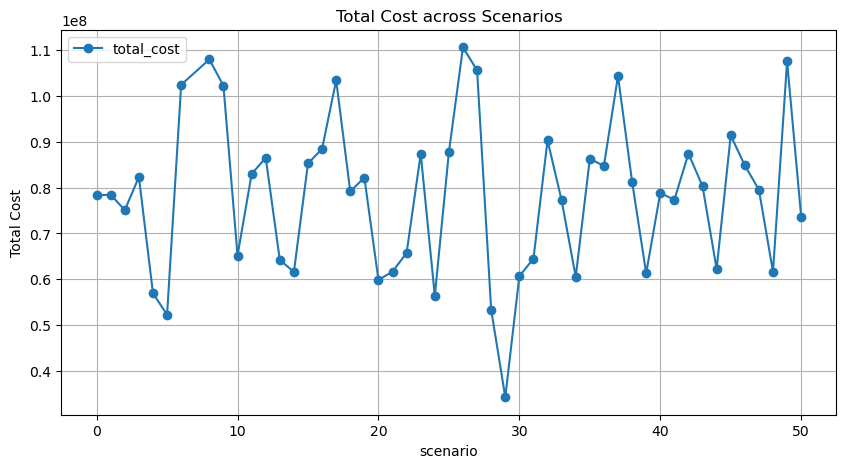

C:\Users\Bura Samshritha\AppData\Local\Temp\ipykernel_3296\3120933195.py:88: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  plant_open_counts = plant_open_counts.applymap(int)


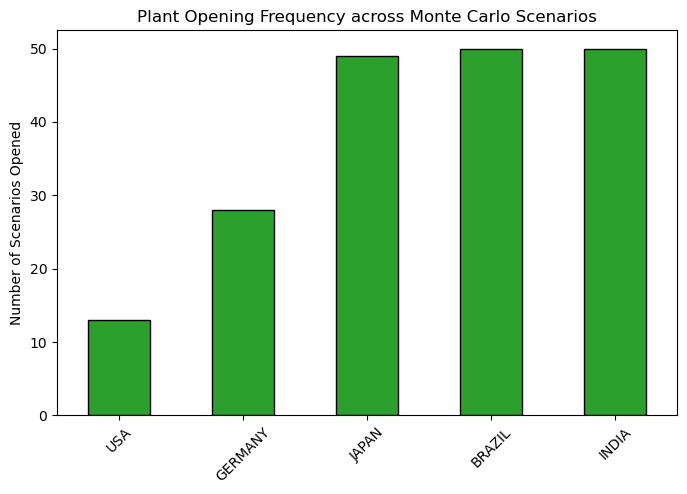

In [85]:
from docplex.mp.model import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
N = 50  # number of scenarios
CV = 0.3  # coefficient of variation (σ/μ)

# Generate demand scenarios
df_demand = pd.DataFrame({"scenario": np.arange(1, N+1)})
for country in countries:
    mu = demand[country]
    sigma = CV * mu
    df_demand[country] = np.random.normal(mu, sigma, N).clip(min=0)

# Add baseline demand as scenario 0
baseline = {"scenario": 0}
baseline.update(demand)
df_demand = pd.concat([pd.DataFrame([baseline]), df_demand], ignore_index=True)

# Function to solve MIQP for a given demand vector
def solve_miqp(demand_dict):
    mdl = Model("SupplyChain_MI_QP")
    n = len(countries)

    # Decision variables
    x = {(i,j): mdl.continuous_var(lb=0, name=f"x_{i}_{j}") 
         for i in range(n) for j in range(n)}
    y = {i: mdl.binary_var(name=f"y_{i}") for i in range(n)}

    # Objective
    total_cost = mdl.sum(
        var_costs[i,i] * x[i,j] + b[i]*x[i,j]**2 + freight_costs[i,j]*x[i,j]
        for i in range(n) for j in range(n)
    ) + mdl.sum(fixed_high[countries[i]] * y[i] for i in range(n))
    mdl.minimize(total_cost)

    # Constraints
    for j in range(n):
        mdl.add_constraint(mdl.sum(x[i,j] for i in range(n)) == demand_dict[countries[j]])
    for i in range(n):
        mdl.add_constraint(mdl.sum(x[i,j] for j in range(n)) <= capacity_high[countries[i]]*y[i])

    sol = mdl.solve(log_output=False)
    if not sol:
        return None

    flows = pd.DataFrame(np.zeros((n,n)), index=countries, columns=countries)
    for i in range(n):
        for j in range(n):
            flows.iloc[i,j] = x[i,j].solution_value

    plant_status = {countries[i]: y[i].solution_value for i in range(n)}
    return sol.objective_value, flows, plant_status

# Run Monte Carlo
results = []
for idx, row in df_demand.iterrows():
    demand_dict = {c: row[c] for c in countries}
    sol = solve_miqp(demand_dict)
    if sol:
        obj, flows, plants = sol
        results.append({
            "scenario": row["scenario"],
            "total_cost": obj,
            "plants": plants
        })
    else:
        results.append({
            "scenario": row["scenario"],
            "total_cost": None,
            "plants": None
        })

results_df = pd.DataFrame(results)

# --- Analysis Plots ---
# Plot total cost per scenario
results_df.dropna().plot(x="scenario", y="total_cost", kind="line", figsize=(10,5), marker="o")
plt.ylabel("Total Cost")
plt.title("Total Cost across Scenarios")
plt.grid(True)
plt.show()

# Plant opening frequency across scenarios
plant_open_counts = pd.DataFrame([r["plants"] for r in results if r["plants"] is not None])
plant_open_counts = plant_open_counts.applymap(int)
plant_open_counts.sum().plot(kind="bar", figsize=(8,5), color="tab:green", edgecolor="black")
plt.ylabel("Number of Scenarios Opened")
plt.title("Plant Opening Frequency across Monte Carlo Scenarios")
plt.xticks(rotation=45)
plt.show()


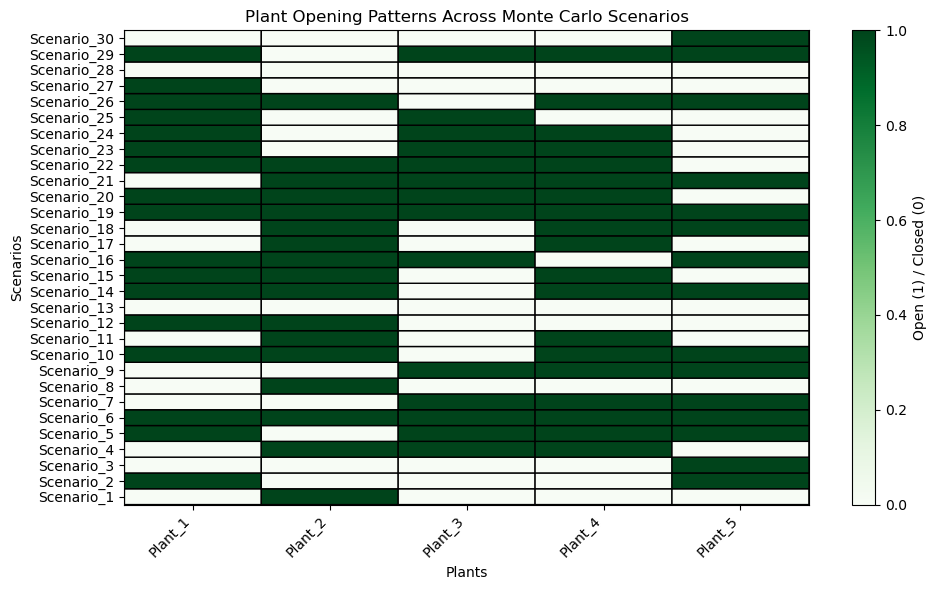

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --------------------------
# Example: Collect results
# --------------------------
# Suppose you ran S Monte Carlo scenarios
# and for each scenario you stored which plants were opened (y[i] ∈ {0,1})
# Let's simulate some dummy results for demo:

n_plants = 5      # number of plants
n_scenarios = 30  # number of Monte Carlo demand scenarios

# Example: random open/close decisions (replace this with your actual results from solver)
np.random.seed(42)
plant_openings = np.random.randint(0, 2, size=(n_scenarios, n_plants))

# Convert to DataFrame for labeling
df_bool = pd.DataFrame(
    plant_openings,
    columns=[f"Plant_{i+1}" for i in range(n_plants)],
    index=[f"Scenario_{s+1}" for s in range(n_scenarios)]
)

# --------------------------
# Heatmap visualization
# --------------------------
plt.figure(figsize=(10, 6))
plt.pcolor(df_bool.values, cmap="Greens", edgecolors='k', linewidths=1)

plt.xticks(np.arange(0.5, n_plants + 0.5), df_bool.columns, rotation=45, ha='right')
plt.yticks(np.arange(0.5, n_scenarios + 0.5), df_bool.index)

plt.xlabel("Plants")
plt.ylabel("Scenarios")
plt.title("Plant Opening Patterns Across Monte Carlo Scenarios")
plt.colorbar(label="Open (1) / Closed (0)")
plt.tight_layout()
plt.show()


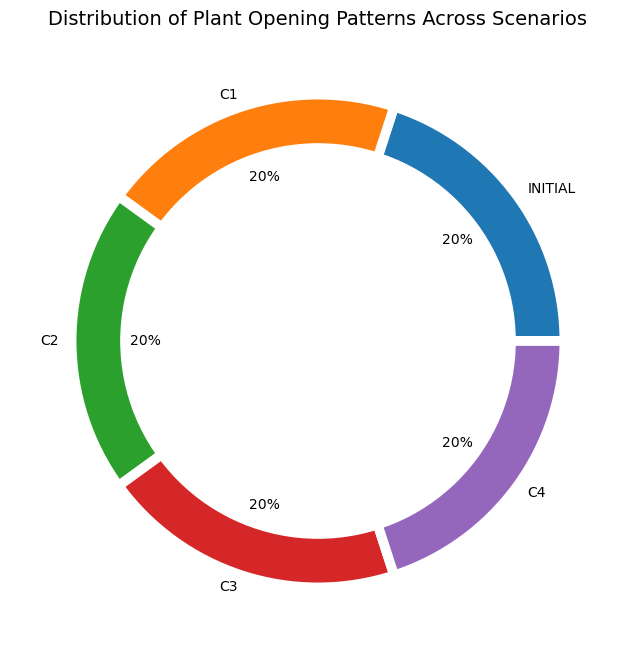

In [88]:
# Pie chart
my_circle = plt.Circle((0,0), 0.8, color='white')
df_comb.plot.pie(
    figsize=(8,8),
    y='count',
    legend=False,
    autopct='%1.0f%%',
    pctdistance=0.7,
    labeldistance=1.05,
    wedgeprops={'linewidth': 7, 'edgecolor':'white'}
)
plt.xlabel('Unique Opening Patterns', fontsize=12)
plt.ylabel('')
plt.title("Distribution of Plant Opening Patterns Across Scenarios", fontsize=14)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.show()


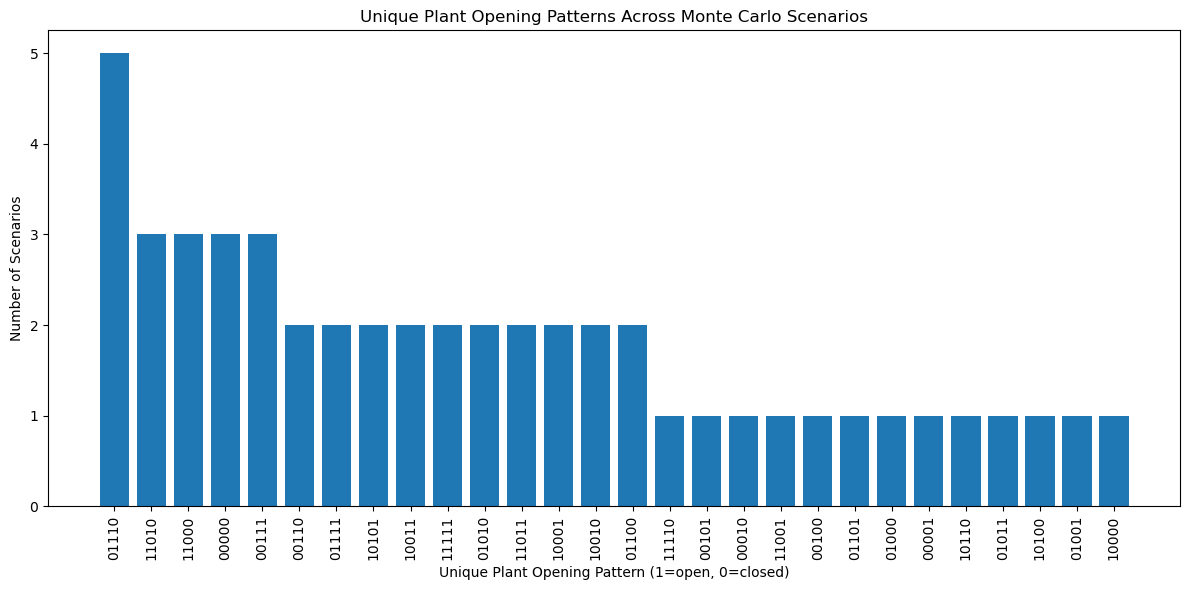

   Pattern  Frequency
0   01110   5        
1   11010   3        
2   11000   3        
3   00000   3        
4   00111   3        
5   00110   2        
6   01111   2        
7   10101   2        
8   10011   2        
9   11111   2        
10  01010   2        
11  11011   2        
12  10001   2        
13  10010   2        
14  01100   2        
15  11110   1        
16  00101   1        
17  00010   1        
18  11001   1        
19  00100   1        
20  01101   1        
21  01000   1        
22  00001   1        
23  10110   1        
24  01011   1        
25  10100   1        
26  01001   1        
27  10000   1        


In [89]:
# ----------------------------------
# Unique Plant Opening Patterns
# ----------------------------------
import pandas as pd

# Convert each row (scenario) to a string pattern like "1010..."
patterns = df_bool.astype(int).astype(str).agg(''.join, axis=1)

# Count unique patterns
pattern_counts = patterns.value_counts().reset_index()
pattern_counts.columns = ["Pattern", "Frequency"]

# Plot bar chart of unique patterns
plt.figure(figsize=(12, 6))
plt.bar(range(len(pattern_counts)), pattern_counts["Frequency"], tick_label=pattern_counts["Pattern"])
plt.xticks(rotation=90)
plt.xlabel("Unique Plant Opening Pattern (1=open, 0=closed)")
plt.ylabel("Number of Scenarios")
plt.title("Unique Plant Opening Patterns Across Monte Carlo Scenarios")
plt.tight_layout()
plt.show()

# If you also want a table of unique patterns + counts
print(pattern_counts)
